In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
data=pd.read_csv("finalpreprocessed_detailed.csv")
gan=pd.read_csv("synthetic_dataGAN.csv").drop(['Unnamed: 0', 'id'], axis=1)
gc=pd.read_csv("synthetic_dataGC.csv").drop(['Unnamed: 0', 'id'], axis=1)
data0=data[data['CVD']==0]
data1=data[data['CVD']==1]
data0=data0.sample(n=16000)
data=pd.concat([data0,data1,gan], axis=0)
data=data.sample(n=32207)
data.shape

(32207, 144)

In [ ]:
selected_features = 'AGEP_A,SEX_A,RACEALLP_A_1,RACEALLP_A_2,RACEALLP_A_3,RACEALLP_A_4,RACEALLP_A_5,RACEALLP_A_6,HYPEV_A,CHLEV_A,DIBTYPE_A_1,DIBTYPE_A_2,DIBTYPE_A_3,SMKCIGST_A_1,SMKCIGST_A_2,SMKCIGST_A_3,SMKCIGST_A_4,HYPMED_A,CVD'
selected_columns = selected_features.split(',')
selected_columns_with_occ = selected_columns.copy()+[col for col in data.columns if col.startswith("EMDOCCUPN") or col.startswith("EMDINDSTN") or col.startswith("EMDWRKCAT")]
pce_features_data = data[selected_columns]
pce_and_occ_features_data = data[selected_columns_with_occ]

# pce_features_data0=pce_features_data[pce_features_data['CVD']==0.0]
# pce_features_data1=pce_features_data[pce_features_data['CVD']==1.0]
# pce_features_data0=pce_features_data0.sample(n=10000, random_state=1)
# pce_features_data=pd.concat([pce_features_data0,pce_features_data1])
# pce_features_data= pce_features_data.sample(frac = 1)

# pce_and_occ_features_data0=pce_and_occ_features_data[pce_and_occ_features_data['CVD']==0.0]
# pce_and_occ_features_data1=pce_and_occ_features_data[pce_and_occ_features_data['CVD']==1.0]
# pce_and_occ_features_data0=pce_and_occ_features_data0.sample(n=10000, random_state=1)
# pce_and_occ_features_data=pd.concat([pce_and_occ_features_data0,pce_and_occ_features_data1])
# pce_and_occ_features_data= pce_and_occ_features_data.sample(frac = 1)

In [ ]:
X = pce_and_occ_features_data.drop('CVD', axis=1)
y = pce_and_occ_features_data['CVD']

In [ ]:
min_max_scaler = MinMaxScaler()
X_normalized = min_max_scaler.fit_transform(X)
standard_scaler = StandardScaler()
X_standardized = standard_scaler.fit_transform(X_normalized)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Model fitting
##Models fitted: Random Forest, LR with weights adjusted, SVM

##Using PCE + Occupation Features

###Random Forest

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Initialize the KFold cross-validator with 10 folds
kf = KFold(n_splits=2, shuffle=True)

total_training_accuracy = 0
total_testing_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
fold = 1


clf = RandomForestClassifier(n_estimators=5, random_state=42)

for train_index, test_index in kf.split(X_standardized):
    X_train, X_test = X_standardized[train_index], X_standardized[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model on the training data
    clf.fit(X_train, y_train)

    # Compute the training accuracy
    training_accuracy = clf.score(X_train, y_train)

    # Make predictions using the test data
    y_test_pred = clf.predict(X_test)

    # Compute the testing accuracy, precision, recall, and F1 score
    testing_accuracy = clf.score(X_test, y_test)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    total_training_accuracy += training_accuracy
    total_testing_accuracy += testing_accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    fold += 1

# Calculate the average training accuracy, testing accuracy, precision, recall, and F1 score
average_training_accuracy = total_training_accuracy / (fold - 1)
average_testing_accuracy = total_testing_accuracy / (fold - 1)
average_precision = total_precision / (fold - 1)
average_recall = total_recall / (fold - 1)
average_f1 = total_f1 / (fold - 1)

#print(f"Average training accuracy: {average_training_accuracy * 100:.2f}%")
print(f"Average testing accuracy: {average_testing_accuracy * 100:.2f}%")
print(f"Average precision: {average_precision:.2f}")
print(f"Average recall: {average_recall:.2f}")
print(f"Average F1 score: {average_f1:.2f}")
print()

Average testing accuracy: 82.11%
Average precision: 0.82
Average recall: 0.83
Average F1 score: 0.82



###Logistic Regression

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize the KFold cross-validator with 10 folds
kf = KFold(n_splits=10)

total_training_accuracy = 0
total_testing_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
fold = 1

lr = LogisticRegression(max_iter=1000)

for train_index, test_index in kf.split(X_standardized):
    X_train, X_test = X_standardized[train_index], X_standardized[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model on the training data
    lr.fit(X_train, y_train)

    # Compute the training accuracy
    training_accuracy = lr.score(X_train, y_train)

    # Make predictions using the test data
    y_test_pred = lr.predict(X_test)

    # Compute the testing accuracy, precision, recall, and F1 score
    testing_accuracy = lr.score(X_test, y_test)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # print(f"Fold {fold}:")
    # print(f"  Training accuracy: {training_accuracy * 100:.2f}%")
    # print(f"  Testing accuracy: {testing_accuracy * 100:.2f}%")
    # print(f"  Precision: {precision:.2f}")
    # print(f"  Recall: {recall:.2f}")
    # print(f"  F1 score: {f1:.2f}")
    # print()

    total_training_accuracy += training_accuracy
    total_testing_accuracy += testing_accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    fold += 1

# Calculate the average training accuracy, testing accuracy, precision, recall, and F1 score
average_training_accuracy = total_training_accuracy / (fold - 1)
average_testing_accuracy = total_testing_accuracy / (fold - 1)
average_precision = total_precision / (fold - 1)
average_recall = total_recall / (fold - 1)
average_f1 = total_f1 / (fold - 1)

#print(f"Average training accuracy: {average_training_accuracy * 100:.2f}%")
print(f"Average testing accuracy: {average_testing_accuracy * 100:.2f}%")
print(f"Average precision: {average_precision:.2f}")
print(f"Average recall: {average_recall:.2f}")
print(f"Average F1 score: {average_f1:.2f}")
print()


Average testing accuracy: 80.72%
Average precision: 0.79
Average recall: 0.83
Average F1 score: 0.81



###SVM

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize the KFold cross-validator with 10 folds
kf = KFold(n_splits=2, shuffle=True)

total_training_accuracy = 0
total_testing_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
fold = 1


clf = svm.SVC()

for train_index, test_index in kf.split(X_standardized):
    X_train, X_test = X_standardized[train_index], X_standardized[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model on the training data
    clf.fit(X_train, y_train)

    # Compute the training accuracy
    training_accuracy = clf.score(X_train, y_train)

    # Make predictions using the test data
    y_test_pred = clf.predict(X_test)

    # Compute the testing accuracy, precision, recall, and F1 score
    testing_accuracy = clf.score(X_test, y_test)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # print(f"Fold {fold}:")
    # print(f"  Training accuracy: {training_accuracy * 100:.2f}%")
    # print(f"  Testing accuracy: {testing_accuracy * 100:.2f}%")
    # print(f"  Precision: {precision:.2f}")
    # print(f"  Recall: {recall:.2f}")
    # print(f"  F1 score: {f1:.2f}")
    # print()

    total_training_accuracy += training_accuracy
    total_testing_accuracy += testing_accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    fold += 1

# Calculate the average training accuracy, testing accuracy, precision, recall, and F1 score
average_training_accuracy = total_training_accuracy / (fold - 1)
average_testing_accuracy = total_testing_accuracy / (fold - 1)
average_precision = total_precision / (fold - 1)
average_recall = total_recall / (fold - 1)
average_f1 = total_f1 / (fold - 1)

#print(f"Average training accuracy: {average_training_accuracy * 100:.2f}%")
print(f"Average testing accuracy: {average_testing_accuracy * 100:.2f}%")
print(f"Average precision: {average_precision:.2f}")
print(f"Average recall: {average_recall:.2f}")
print(f"Average F1 score: {average_f1:.2f}")
print()


Average testing accuracy: 83.85%
Average precision: 0.84
Average recall: 0.83
Average F1 score: 0.84



###Neural Networks

####Finding best model architecture

In [ ]:
# build a model
model = Sequential()
model.add(Dense(20, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='Adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy',
                                   mode='max', # don't minimize the accuracy!
                                   patience=5,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=30, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.3,
                    shuffle=True,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1980      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,201
Trainable params: 2,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1128/1128 [==============================] - 4s 3ms/step - loss: 0.4820 - accuracy: 0.7656 - val_loss: 0.4309 - val_accuracy: 0.7997
Epoch 2/30
1128/1128 [==============================] - 4s 3ms/step - loss: 0.3838 - accuracy: 0.8245 - val_loss: 0.4122 - val_accuracy: 0.8024
Epoch 3/30
1128/1128 [========

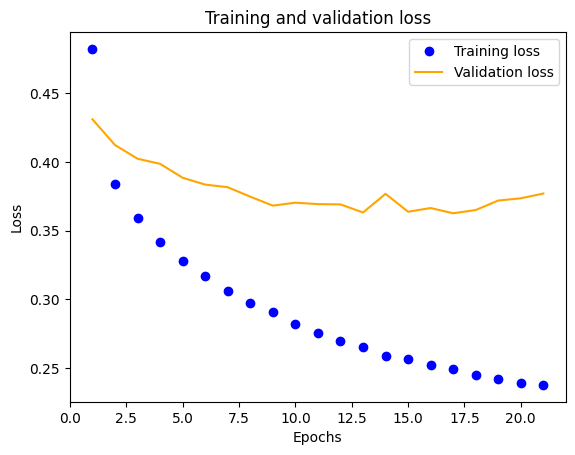

In [ ]:
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

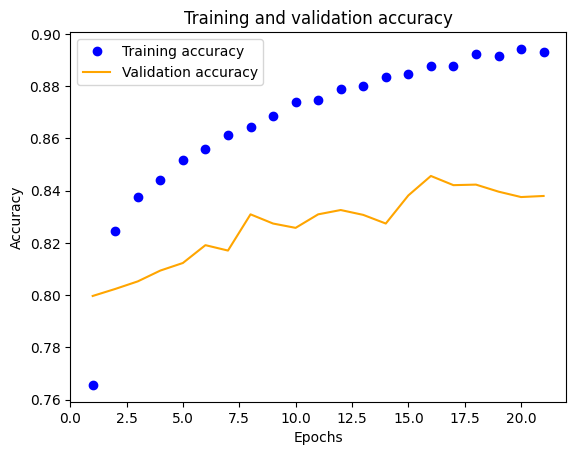

0.8456125855445862

In [ ]:
# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = np.round(model.predict(X_test),0)

# confusion matrix
print(confusion_matrix(y_test, preds)) # order matters! (actual, predicted)

print(classification_report(y_test, preds))

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)


504/504 [==============================] - 1s 1ms/step
[[6696 1254]
 [1455 6698]]
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83      7950
         1.0       0.84      0.82      0.83      8153

    accuracy                           0.83     16103
   macro avg       0.83      0.83      0.83     16103
weighted avg       0.83      0.83      0.83     16103



(6696, 1254, 1455, 6698)

##Using PCE

In [ ]:
X = pce_features_data.drop('CVD', axis=1)
y = pce_features_data['CVD']

In [ ]:
min_max_scaler = MinMaxScaler()
X_normalized = min_max_scaler.fit_transform(X)
standard_scaler = StandardScaler()
X_standardized = standard_scaler.fit_transform(X_normalized)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###Random Forest

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Initialize the KFold cross-validator with 10 folds
kf = KFold(n_splits=2, shuffle=True)

total_training_accuracy = 0
total_testing_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
fold = 1


clf = RandomForestClassifier(n_estimators=10, random_state=42)

for train_index, test_index in kf.split(X_standardized):
    X_train, X_test = X_standardized[train_index], X_standardized[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model on the training data
    clf.fit(X_train, y_train)

    # Compute the training accuracy
    training_accuracy = clf.score(X_train, y_train)

    # Make predictions using the test data
    y_test_pred = clf.predict(X_test)

    # Compute the testing accuracy, precision, recall, and F1 score
    testing_accuracy = clf.score(X_test, y_test)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print(f"Fold {fold}:")
    print(f"  Testing accuracy: {testing_accuracy * 100:.2f}%")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 score: {f1:.2f}")
    print()

    # confusion matrix
    print(confusion_matrix(y_test, y_test_pred)) # order matters! (actual, predicted)

    print(classification_report(y_test, y_test_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    (tn, fp, fn, tp)

    total_training_accuracy += training_accuracy
    total_testing_accuracy += testing_accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    fold += 1

# Calculate the average training accuracy, testing accuracy, precision, recall, and F1 score
average_training_accuracy = total_training_accuracy / (fold - 1)
average_testing_accuracy = total_testing_accuracy / (fold - 1)
average_precision = total_precision / (fold - 1)
average_recall = total_recall / (fold - 1)
average_f1 = total_f1 / (fold - 1)

#print(f"Average training accuracy: {average_training_accuracy * 100:.2f}%")
print(f"Average testing accuracy: {average_testing_accuracy * 100:.2f}%")
print(f"Average precision: {average_precision:.2f}")
print(f"Average recall: {average_recall:.2f}")
print(f"Average F1 score: {average_f1:.2f}")
print()

Fold 1:
  Testing accuracy: 80.38%
  Precision: 0.82
  Recall: 0.78
  F1 score: 0.80

[[6618 1418]
 [1741 6327]]
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.81      8036
         1.0       0.82      0.78      0.80      8068

    accuracy                           0.80     16104
   macro avg       0.80      0.80      0.80     16104
weighted avg       0.80      0.80      0.80     16104

Fold 2:
  Testing accuracy: 80.43%
  Precision: 0.82
  Recall: 0.79
  F1 score: 0.80

[[6547 1417]
 [1734 6405]]
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.81      7964
         1.0       0.82      0.79      0.80      8139

    accuracy                           0.80     16103
   macro avg       0.80      0.80      0.80     16103
weighted avg       0.80      0.80      0.80     16103

Average testing accuracy: 80.41%
Average precision: 0.82
Average recall: 0.79
Average F1 score: 0.80



###Logistic Regression

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize the KFold cross-validator with 10 folds
kf = KFold(n_splits=10)

total_training_accuracy = 0
total_testing_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
fold = 1

lr = LogisticRegression(max_iter=1000)

for train_index, test_index in kf.split(X_standardized):
    X_train, X_test = X_standardized[train_index], X_standardized[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model on the training data
    lr.fit(X_train, y_train)

    # Compute the training accuracy
    training_accuracy = lr.score(X_train, y_train)

    # Make predictions using the test data
    y_test_pred = lr.predict(X_test)

    # Compute the testing accuracy, precision, recall, and F1 score
    testing_accuracy = lr.score(X_test, y_test)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # print(f"Fold {fold}:")
    # print(f"  Training accuracy: {training_accuracy * 100:.2f}%")
    # print(f"  Testing accuracy: {testing_accuracy * 100:.2f}%")
    # print(f"  Precision: {precision:.2f}")
    # print(f"  Recall: {recall:.2f}")
    # print(f"  F1 score: {f1:.2f}")
    # print()

    total_training_accuracy += training_accuracy
    total_testing_accuracy += testing_accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    fold += 1

# Calculate the average training accuracy, testing accuracy, precision, recall, and F1 score
average_training_accuracy = total_training_accuracy / (fold - 1)
average_testing_accuracy = total_testing_accuracy / (fold - 1)
average_precision = total_precision / (fold - 1)
average_recall = total_recall / (fold - 1)
average_f1 = total_f1 / (fold - 1)

#print(f"Average training accuracy: {average_training_accuracy * 100:.2f}%")
print(f"Average testing accuracy: {average_testing_accuracy * 100:.2f}%")
print(f"Average precision: {average_precision:.2f}")
print(f"Average recall: {average_recall:.2f}")
print(f"Average F1 score: {average_f1:.2f}")
print()

Average testing accuracy: 79.72%
Average precision: 0.78
Average recall: 0.83
Average F1 score: 0.81



###SVM

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Initialize the KFold cross-validator with 10 folds
kf = KFold(n_splits=2, shuffle=True)

total_training_accuracy = 0
total_testing_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
fold = 1


clf = svm.SVC()

for train_index, test_index in kf.split(X_standardized):
    X_train, X_test = X_standardized[train_index], X_standardized[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model on the training data
    clf.fit(X_train, y_train)

    # Compute the training accuracy
    training_accuracy = clf.score(X_train, y_train)

    # Make predictions using the test data
    y_test_pred = clf.predict(X_test)

    # Compute the testing accuracy, precision, recall, and F1 score
    testing_accuracy = clf.score(X_test, y_test)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # print(f"Fold {fold}:")
    # print(f"  Training accuracy: {training_accuracy * 100:.2f}%")
    # print(f"  Testing accuracy: {testing_accuracy * 100:.2f}%")
    # print(f"  Precision: {precision:.2f}")
    # print(f"  Recall: {recall:.2f}")
    # print(f"  F1 score: {f1:.2f}")
    # print()

    total_training_accuracy += training_accuracy
    total_testing_accuracy += testing_accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    fold += 1

# Calculate the average training accuracy, testing accuracy, precision, recall, and F1 score
average_training_accuracy = total_training_accuracy / (fold - 1)
average_testing_accuracy = total_testing_accuracy / (fold - 1)
average_precision = total_precision / (fold - 1)
average_recall = total_recall / (fold - 1)
average_f1 = total_f1 / (fold - 1)

#print(f"Average training accuracy: {average_training_accuracy * 100:.2f}%")
print(f"Average testing accuracy: {average_testing_accuracy * 100:.2f}%")
print(f"Average precision: {average_precision:.2f}")
print(f"Average recall: {average_recall:.2f}")
print(f"Average F1 score: {average_f1:.2f}")
print()

Average training accuracy: 82.66%
Average testing accuracy: 81.99%
Average precision: 0.80
Average recall: 0.85
Average F1 score: 0.83



###Neural Networks

####Finding best weight on model (20,10)

In [ ]:
# build a model
model = Sequential()
model.add(Dense(20, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='Adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy',
                                   mode='max', # don't minimize the accuracy!
                                   patience=5,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=30, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.3,
                    shuffle=True,
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                380       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1128/1128 [==============================] - 4s 3ms/step - loss: 0.4526 - accuracy: 0.7933 - val_loss: 0.4142 - val_accuracy: 0.8075
Epoch 2/30
1128/1128 [==============================] - 3s 3ms/step - loss: 0.3938 - accuracy: 0.8183 - val_loss: 0.3912 - val_accuracy: 0.8146
Epoch 3/30
1128/1128 [==========

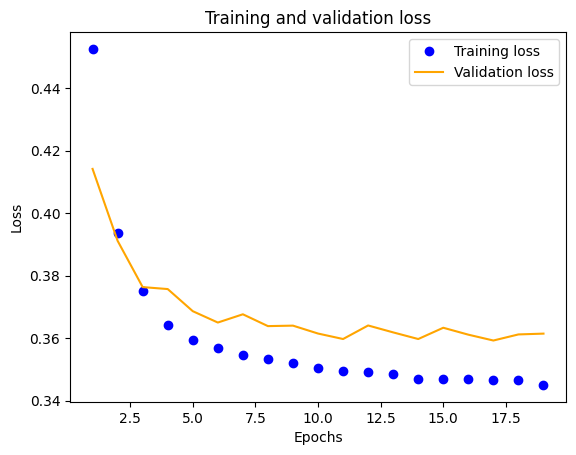

In [ ]:
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

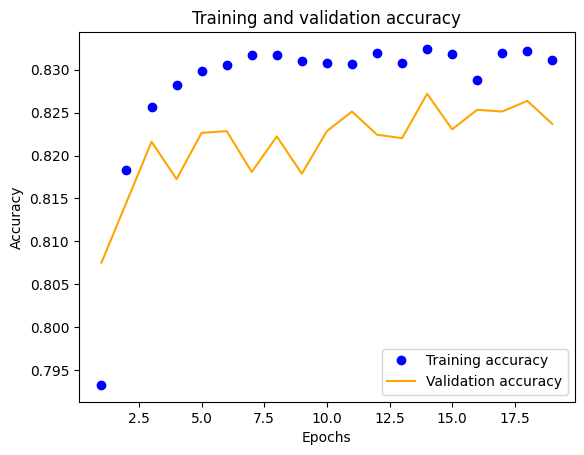

0.8271937370300293

In [ ]:
# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = np.round(model.predict(X_test),0)

# confusion matrix
print(confusion_matrix(y_test, preds)) # order matters! (actual, predicted)

print(classification_report(y_test, preds))

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)

504/504 [==============================] - 1s 1ms/step
[[6463 1498]
 [1394 6748]]
              precision    recall  f1-score   support

         0.0       0.82      0.81      0.82      7961
         1.0       0.82      0.83      0.82      8142

    accuracy                           0.82     16103
   macro avg       0.82      0.82      0.82     16103
weighted avg       0.82      0.82      0.82     16103



(6463, 1498, 1394, 6748)